In [1]:
###
# Instructor: Run first two cells. 
# Third cell computes the features of one image in one of the "50_categories" directories to get a sense of how long it takes for a single image
# Fourth cell contains run_final_classifier
###


###
# Import everything first
###

import sklearn
import skimage
import skimage.io
import numpy as np
import pandas as pd

from skimage.feature import daisy
from skimage.feature import hog
from skimage import data
from skimage.filters import roberts, sobel, scharr, prewitt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import model_selection

from itertools import product
from multiprocessing import Pool
from os import listdir
from os.path import isfile, join
import pickle

#there's a depreciation warning for skimage.features.hog that keeps popping up
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


In [2]:
###
# Define functions to read files & compute features
###

def getFilesInDirectory(mypath):
    """Returns list of all filenames in given directory"""
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    return onlyfiles

def setupData(directory = "50_categories",only_first = 1000):
    """Input: Directory containing directories for each class - the directory names are the class names
    only_first: For testing mostly - only computes first only_first directories
    balanced: samples from lesser represented classes enough so that every class has an equal representation in the data set
    Output:
    files: a list of the filenames of every image
    X: a list of the feature lists of every image
    Y: a list of the classes of every image"""
    max_samples = 533 #in this training data, airplane has 533 samples
    
    files = []
    X = []
    Y = []
    for class_folder in listdir(directory)[:only_first]:
        if class_folder[0] != ".":
            filename_list, features_list = getFeaturesFromDirectory(join(directory,class_folder))
            class_list = [class_folder]*len(filename_list)
            files += filename_list
            X += features_list
            Y += class_list
            print("Finished " + class_folder + ".")
    print("Finished.")
    return files, X, Y
    
#Load images from directory and compute features
def getFeaturesFromDirectory(path):
    """Input: directory containing images
    Output: filename_list: a list of the file names in the directory
    features_list: a list of the feature lists for each image in the directory"""
    filename_list = getFilesInDirectory(path)
    filepath_list = [join(path,filename) for filename in filename_list]
    pool = Pool(processes=6)
    features_list = pool.map(getFeaturesFromImage,filepath_list)
    pool.close()
    #features_list = [getFeaturesFromImage(join(path,filename)) for filename in filename_list]
    return filename_list,features_list

def getFeaturesFromImage(filepath):
    """Computes a list of features from the file name for a single image."""
    features = []
    #print(filepath)
    image = skimage.io.imread(filepath) #load image
    image = skimage.img_as_ubyte(image) #make sure they're all the same format
    
    greyQ = len(np.shape(image))== 2 #is it grey
    if greyQ: #convert to color if grey
        image = skimage.color.gray2rgb(image, alpha=None)
    imageGrey = skimage.color.rgb2grey(image)
    
    #Image size and ratio
    len_x,len_y = np.shape(image[:,:,0])
    image_size = len_x*len_y
    image_ratio = len_x/len_y
    features += [image_size,image_ratio]
    
    #Discretize colors into N^3 sectors - feature is fraction of image in each sector
    #This inherently contains correlations between colors
    N = 5
    im_discr = image[:,:,0]//(256/N) + N*(image[:,:,1]//(256/N)) + (N**2)*(image[:,:,2]//(256/N))
    discr_colors = [np.sum(im_discr == color,axis=(0,1))/image_size for color in range(N**3)]
    features += discr_colors

    # Parameters related to "number of edges" in coarse-grained blocks of image
    # Normalize sorbel image by sqrt(L_x*L_y) because gradient ~1/L_x, so mean of gradient ~1/L_x ~ 1/sqrt(L_x*L_y)
    # This normalization tries to capture "Number of edges"
    # Density of edges should be divided by L_x*L_y presumably...
    # Uses Sobel edge filter
    Nedge = 10
    xlims = np.round(np.linspace(0,len_x,Nedge)).astype(int)
    ylims = np.round(np.linspace(0,len_y,Nedge)).astype(int)
    subimages = [imageGrey[xlims[i]:xlims[i+1],ylims[j]:ylims[j+1]] for i,j in product(range(Nedge-1),range(Nedge-1))]
    edge_sobels = [sobel(image) for image in subimages]

    means_sobel_grid = [np.mean(im) for im in edge_sobels] #number of edges in sector
    stds_sobel_grid = [np.std(im) for im in edge_sobels] #"spread" of edges in sector (blurriness)

    mean_of_mean = np.mean(means_sobel_grid)
    fraction_greater_mean = np.mean(means_sobel_grid > mean_of_mean)
    std_of_mean = np.std(means_sobel_grid)
    max_of_mean = np.max(means_sobel_grid)
    mean_of_std = np.mean(stds_sobel_grid)
    std_of_std = np.std(stds_sobel_grid)

    features += [mean_of_mean,fraction_greater_mean,std_of_mean,max_of_mean,mean_of_std,std_of_std]
    
    #Histograms of Oriented Gradients
    num_or = 7
    H = hog(imageGrey, orientations=num_or, pixels_per_cell=(20,20),cells_per_block=(1,1),block_norm="L1", transform_sqrt=True,feature_vector=False)
    H = np.sum(H,axis=(2,3))

    fullhist = list(np.sum(H,axis=(0,1)))
    features += fullhist

    maxs = np.max(H,axis=2)
    features += [np.mean(maxs),np.std(maxs),np.sum(maxs>np.mean(maxs))]
    #["HOG max mean","HOG max std","HOG max frac greater"]

    ormaxs = np.argmax(H,axis=2)
    fullhist_ormaxs = [np.sum(ormaxs==i) for i in range(np.shape(H)[2])]
    features += fullhist_ormaxs
    #["HOG fullhist_ormaxs " + str(i) for i in range(len(fullhist_ormaxs))]

    #Unfold to 360 degrees (twice orientations range...nematic vs. vector thing) and get average x and y
    ors = np.linspace(0,2*np.pi,num_or+1)[:-1]
    xs,ys = np.cos(ors),np.sin(ors) #xs for x & y (+ and -), ys for diagonal
    xavgs = np.mean(np.sum(xs*H[None,None,:],axis=(0,1)),axis=2)
    yavgs = np.mean(np.sum(ys*H[None,None,:],axis=(0,1)),axis=2)
    xabsavgs = np.mean(np.sum(np.abs(xs)*H[None,None,:],axis=(0,1)),axis=2)
    yabsavgs = np.mean(np.sum(np.abs(ys)*H[None,None,:],axis=(0,1)),axis=2)

    features += [np.mean(xavgs),np.std(xavgs),np.mean(yavgs),np.std(yavgs),np.mean(xabsavgs),np.std(xabsavgs),np.mean(yabsavgs),np.std(yabsavgs)]

    #Compute discretized colors for most and least edgy regions
    subimages_discr = [im_discr[xlims[i]:xlims[i+1],ylims[j]:ylims[j+1]] for i,j in product(range(Nedge-1),range(Nedge-1))]
    edgy_subimage_discr = subimages_discr[np.argmax(means_sobel_grid)]
    flat_subimage_discr = subimages_discr[np.argmin(means_sobel_grid)]
    
    len_x,len_y = np.shape(image[:,:,0])
    image_size = len_x*len_y
    
    #Most edgy
    edgy_discr_colors = [np.sum(edgy_subimage_discr == color,axis=(0,1))/image_size for color in range(N**3)]
    toptwocolors = list(np.argsort(-np.asarray(edgy_discr_colors)[:2]))
    toptwovalues = list(np.sort(-np.asarray(edgy_discr_colors)[:2]))
    features += toptwocolors + toptwovalues
    
    #Least edgy
    flat_discr_colors = [np.sum(flat_subimage_discr == color,axis=(0,1))/image_size for color in range(N**3)]
    toptwocolors = list(np.argsort(-np.asarray(flat_discr_colors)[:2]))
    toptwovalues = list(np.sort(-np.asarray(flat_discr_colors)[:2]))
    features += toptwocolors + toptwovalues
    
    return features

#String with names of features
N = 5
orientations = 7
feature_string = ["Image size","Image ratio (x/y)"] + \
["Color sector (" + str((R_val,G_val,B_val)) + ")" for R_val,G_val,B_val in product(range(N),range(N),range(N))] + \
["Sorbel mean_of_mean","Sorbel fraction_greater_mean","Sorbel std_of_mean","Sorbel max_of_mean","Sorbel mean_of_std","Sorbel std_of_std"] + \
["HOG fullhist " + str(i) for i in range(orientations)] + \
["HOG max mean","HOG max std","HOG max frac greater"] + \
["HOG fullhist_ormaxs " + str(i) for i in range(orientations)] + \
["HOG X mean","HOG X std","HOG Y mean","HOG Y std","HOG Xa mean","HOG Xa std","HOG Ya mean","HOG Ya std"] + \
["Most Edgy Region: Top color","Most Edgy Region: Second top color","Most Edgy Region: Top color amount","Most Edgy Region: Second top color amount"] + \
["Least Edgy Region: Top color","Least Edgy Region: Second top color","Least Edgy Region: Top color amount","Least Edgy Region: Second top color amount"]

In [3]:
###
# Check time to compute features from a single image
###

category = "giraffe"
filepath = "50_categories/" + category + "/" + listdir("50_categories/" + category + "/")[10]

%timeit getFeaturesFromImage("50_categories/gorilla/gorilla_0003.jpg")

91.6 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
###
# Instructor run this to compute classes!
###

def run_final_classifier(path,output_filename = "predicted_classes.txt"):
    """
    Makes predictions using saved classifier on a directory of test images and writes output to file
    Input: path: directory name containing all test images, output_file
    output_filename: name for output file"""
    loaded_classifier = pickle.load(open('final_model.p', 'rb'))
    le = pickle.load(open("label_encoder.p","rb"))
    filename_list, features_list = getFeaturesFromDirectory(path) #get list of features from directory
    X = np.asarray(features_list)
    Y_pred = loaded_classifier.predict(X) #classify with loaded model
    
    #Write output
    f = open(output_filename, 'w')
    f.write("filename" + "\t\t\t" + "predicted_class" + "\n")
    f.write("-"*40 + "\n")
    for filename,Y in zip(filename_list,le.inverse_transform(Y_pred)):
        f.write(str(filename) + "\t\t\t" + str(Y) + "\n")
    f.close()
    print("Finished prediction. Output printed to " + output_filename + ".")
    return

new_directory_path = "50_categories/helicopter"
run_final_classifier(new_directory_path)

Finished prediction. Output printed to predicted_classes.txt.


In [20]:
###
# Compute features from training and test data
###

files, X, Y = setupData(only_first = 1000)
X = np.asarray(X)

pickle.dump([files,X,Y],open("fXY.p","wb"))

###
# Saved classes to file
###

classes = [direc for direc in listdir("50_categories") if direc[0]!="."]
le = preprocessing.LabelEncoder()
le.fit(classes)

pickle.dump(le,open("label_encoder.p","wb"))


Finished gorilla.
Finished raccoon.
Finished crab.
Finished blimp.
Finished snail.
Finished airplanes.
Finished dog.
Finished dolphin.
Finished goldfish.
Finished giraffe.
Finished bear.
Finished killer-whale.
Finished penguin.
Finished zebra.
Finished duck.
Finished conch.
Finished camel.
Finished owl.
Finished helicopter.
Finished starfish.
Finished saturn.
Finished galaxy.
Finished goat.
Finished iguana.
Finished elk.
Finished hummingbird.
Finished triceratops.
Finished porcupine.
Finished teddy-bear.
Finished comet.
Finished hot-air-balloon.
Finished leopards.
Finished toad.
Finished mussels.
Finished kangaroo.
Finished speed-boat.
Finished bat.
Finished swan.
Finished octopus.
Finished frog.
Finished cormorant.
Finished unicorn.
Finished horse.
Finished skunk.
Finished mars.
Finished ostrich.
Finished goose.
Finished llama.
Finished snake.
Finished elephant.
Finished.


LabelEncoder()

In [3]:
###
# Load previously saved features
###

files,X,Y = pickle.load(open("fXY.p","rb"))

In [14]:
###
# Using 5-fold Cross-Validation to choose hyperparameters with GridSearchCV
# Prints CV score of random-choice model, no features model (picks the most popular category), and optimal model
###

le = preprocessing.LabelEncoder()
le.fit(Y)
Y_num = le.transform(Y) 

#Partition data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_num, test_size=0.2, random_state=42)

#Find hyperparameters via cross-validation
parameters = {'n_estimators':[100],  'max_features':[20,120], 'max_depth':[18,20,22,24],
             'criterion': ['gini']} #,'entropy'
rf_tune = model_selection.GridSearchCV(RandomForestClassifier(), parameters, 
                                   n_jobs = -1, cv = 5,verbose=1)

#Score computed with 5-fold cross-validation
#Using no features (for comparison):
print("Random model would have score: " + str(1./len(le.classes_)))
rf_opt = rf_tune.fit(0.*X_train, Y_train) #the grid search is overkill here
print("Model with no features (picking most popular category) would have score: " + str(rf_opt.best_score_))

#With all features:
rf_opt = rf_tune.fit(X_train, Y_train)
print("Optimal model has score: " + str(rf_opt.best_score_))
print("Optimal model parameters are: " + str(rf_opt.best_params_))

Random model would have score: 0.02
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


Model with no features (picking most popular category) would have score: 0.124005891016
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.6min finished


Optimal model has score: 0.377319587629
Optimal model parameters are: {'criterion': 'gini', 'max_depth': 22, 'max_features': 120, 'n_estimators': 100}


In [31]:
###
# Fit model with chosen hyperparameters to data
###

files, X, Y = pickle.load(open("fXY.p","rb"))

le = preprocessing.LabelEncoder()
le.fit(Y)
Y_num = le.transform(Y) 

#Partition data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_num, test_size=0.2, random_state=42)

#Random forest classifier
#classifier = RandomForestClassifier(**rf_opt.best_params_)
classifier = RandomForestClassifier(criterion="gini",max_features=120,n_estimators = 165,max_depth=20) #max_depth reduced for filesize limitations when pushing to github
#Score classifier with these hyperparameters via cross-validation
classifier.fit(X_train, Y_train) #Fit the classification model on training set

#save the model
filename = 'final_model.p'
pickle.dump(classifier, open(filename, 'wb'))


Feature ranking:
1. Image ratio (x/y)                     0.139005
2. Image size                            0.038425
3. HOG Y std                             0.024363
4. Color sector ((0, 0, 0))              0.022805
5. HOG fullhist_ormaxs 5                 0.022241
6. HOG X mean                            0.020603
7. Sorbel mean_of_mean                   0.016502
8. Sorbel max_of_mean                    0.013770
9. Color sector ((0, 1, 1))              0.013377
10. Sorbel mean_of_std                   0.012621


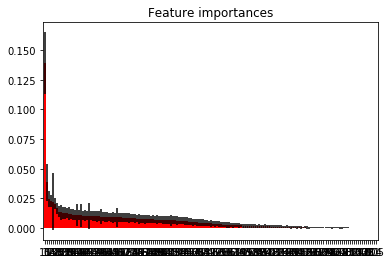

In [34]:
###
#Feature importances
###

import matplotlib.pyplot as plt

importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#Print top 3 features
for f in range(10):
    print(("%d. %s" % (f + 1, feature_string[indices[f]])).ljust(40) + " %f" % (importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [35]:
###
# Evaluate performance on test data
###

Y_pred = classifier.predict(X_test)
score = np.mean(Y_test == Y_pred)

print("Test data score: " + str(score))

Test data score: 0.37691401649


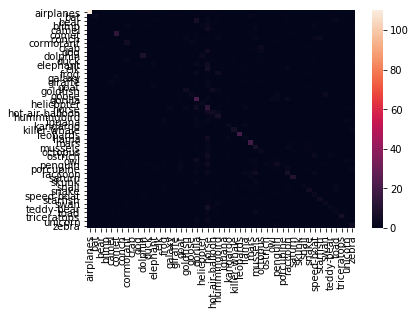

In [36]:
###
# Confusion matrix - should be normalized to be visually useful for unbalanced data (e.g. way more airplanes than gorillas)
###

from sklearn import metrics
import seaborn as sns

rf_confmat = metrics.confusion_matrix(Y_test, Y_pred) # conf mat

sns.heatmap(rf_confmat, annot=False,  fmt='', 
            xticklabels=le.classes_, yticklabels=le.classes_);